<a href="https://colab.research.google.com/github/VivekMuraleedharanGit/fastai_learning/blob/main/Pets_breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pets Breed Image classification using the fastai and PyTorch

In this notebook I'm trying to create a dog vs cat classifier with the help of fastai and pytorch.This was covered as part of fastai coursehttps://docs.fast.ai/tutorial.vision.html


In [ ]:
!pip install fastai --upgrade

In [1]:
from fastai.vision.all import *


In [2]:
#dataset for the cat vs dogs

path = untar_data(URLs.PETS)


In [3]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [4]:
files = get_image_files(path/'images')
len(files)

7390

To label our data for the cats vs dogs problem, we need to know which filenames are of dog pictures and which ones are of cat pictures. There is an easy way to distinguish: the name of the file begins with a capital for cats, and a lowercased letter for dogs

In [9]:
files[2],files[3]

(Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_54.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_47.jpg'))

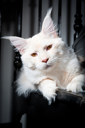

In [12]:
Image.open(files[2]).to_thumb(128,128)

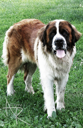

In [13]:
Image.open(files[3]).to_thumb(128,128)

In [27]:
#label fucntion 

def label_func(f): 
  if f[0].isupper():
    return "cat"
  else:
    return "dog"


In [28]:

#creating a DataLoaders object
dls= ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(224))


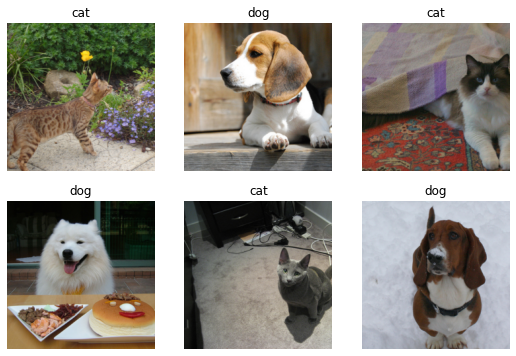

In [29]:
dls.show_batch(max_n=6)

In [30]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.141188,0.020354,0.006089,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.057923,0.014340,0.006766,00:49


In [31]:
learn.predict(files[0])


('cat', tensor(0), tensor([1.0000e+00, 1.7394e-06]))

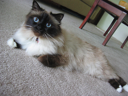

In [34]:
#the original image of files[0]

Image.open(files[0]).to_thumb(128,128)

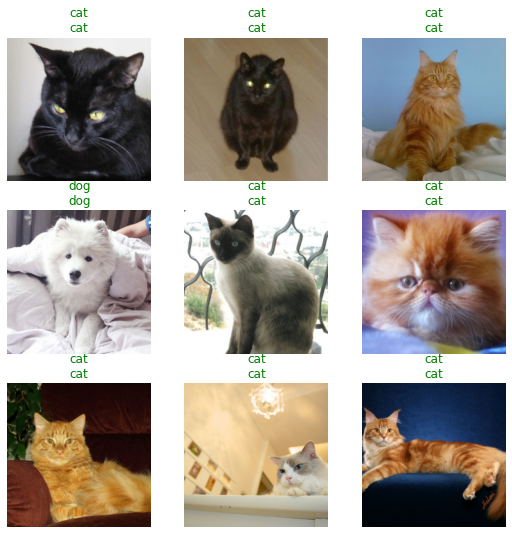

In [36]:
#checking the predictions
learn.show_results()

It's done a good job while predicting the images 

Now in this notebook we will go one step advanced by trying to predict the breed of the cat/dog

The breed of the cat/dog can be identfy from the file name of the image
eg :** /root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_54.jpg'** the breed nam is Maine_Coon 
With the help of regualr expression and from_name_re function we can create dataloaders 

In [37]:
#extracting the breed name alone from the files
pat = r'^(.*)_\d+.jpg'

In [40]:
dls = ImageDataLoaders.from_name_re(path,files,pat,item_tfms=Resize(224))

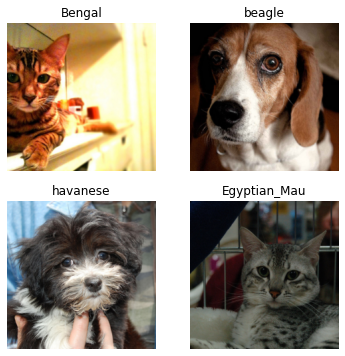

In [42]:
dls.show_batch(max_n=4)

The breed classification is harder as compared with cat/dog classification we need to produce more data for learning the algorithm

With the help of the Augmentation we can produce more images 

In [43]:
#dataloader with augmentation

dls = ImageDataLoaders.from_name_re(path,files,pat,item_tfms= Resize(460),
                                    batch_tfms= aug_transforms(size=224))

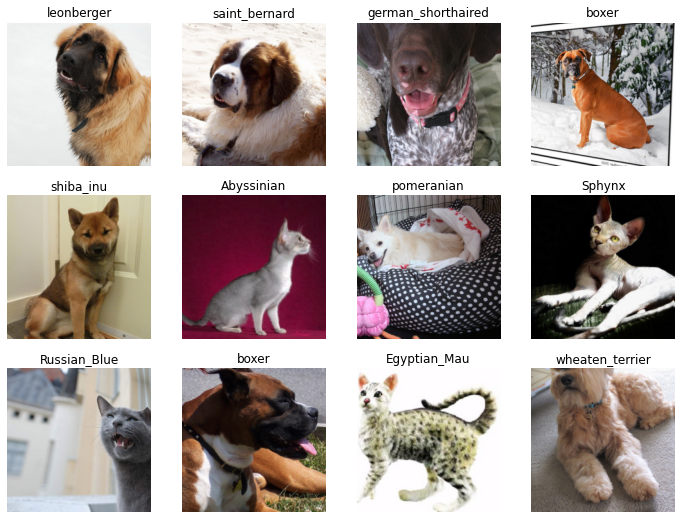

In [45]:
dls.show_batch(max_n=12)

In [46]:
#model 

learn = cnn_learner(dls, resnet34, metrics=error_rate)

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.004365158267319202)

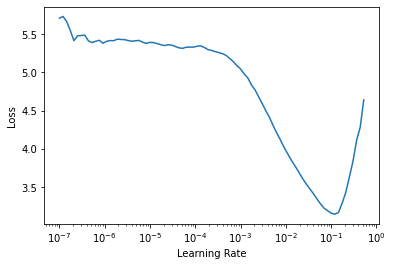

In [47]:
learn.lr_find()

In [48]:
learn.fine_tune(2,4e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.177489,0.339272,0.119080,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.577687,0.470657,0.139378,01:05
1,0.346053,0.214000,0.074425,01:05


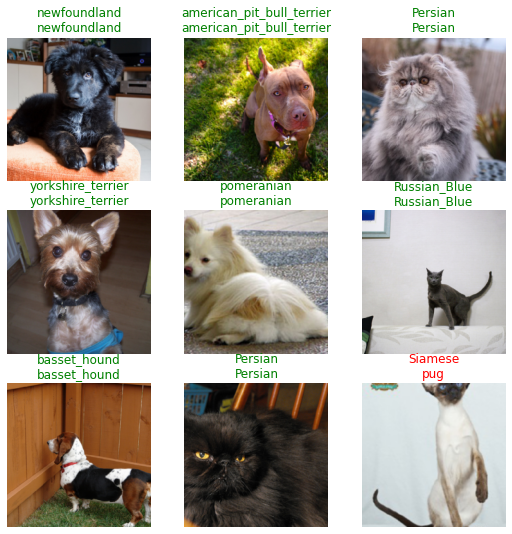

In [49]:
learn.show_results()

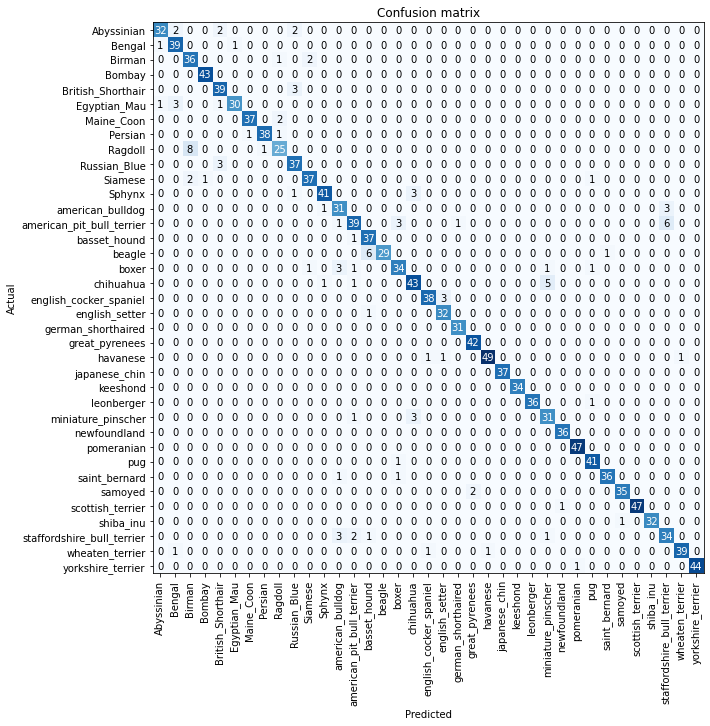

In [52]:
#checking the worst predictions of the model with confusion matrix

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

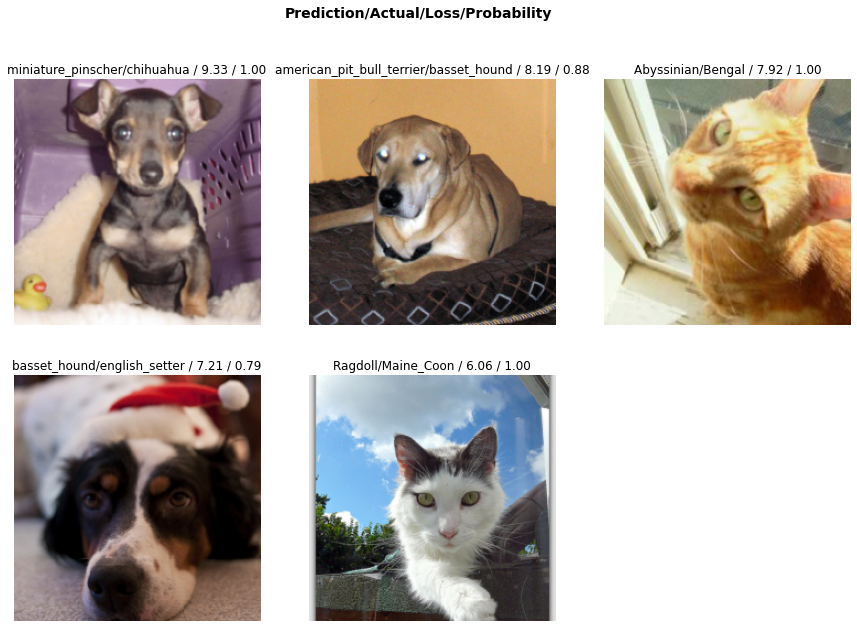

In [58]:
#checking the top_losses

interp.plot_top_losses(5,figsize=(15,10))